## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

#gpu사용
config= tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

In [2]:
print(tf.__version__)

2.3.0


## Load Data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

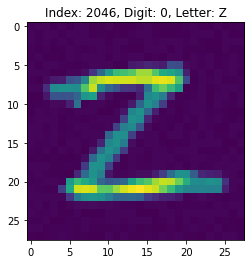

In [4]:
idx = 2046
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## Train model

In [5]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_edit=x_train
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [6]:
threshold=140 #임계값
for i in range(0,2048):
    for j in range(0,28):
        for k in range(0,28):
            if(x_edit[i][j][k][0]<=threshold):
                x_edit[i][j][k][0]=0
            else:
                x_edit[i][j][k][0]=255/255

In [7]:
#결과확인
print(x_edit[2046][7])
print(x_train[2046][7])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
[[0.00784314]
 [0.        ]
 [0.02352941]
 [0.07058824]
 [0.07843137]
 [0.23921569]
 [0.26666667]
 [0.43921569]
 [0.83529412]
 [0.89803922]
 [0.92941176]
 [0.92156863]
 [0.91764706]
 [0.92156863]
 [0.88627451]
 [0.88627451]
 [0.94117647]
 [0.95294118]
 [0.93333333]
 [0.70980392]
 [0.21960784]
 [0.        ]
 [0.01568627]
 [0.00784314]
 [0.01176471]
 [0.        ]
 [0.00392157]
 [0.00784314]]


---

In [8]:
x_train1 = np.repeat(x_train, 3, axis=1)
x_train2 = np.repeat(x_train1, 3, axis=2)
x_edit1=np.repeat(x_edit, 3, axis=1)
x_edit2=np.repeat(x_edit1, 3, axis=2)

In [9]:
print(x_train2.shape, x_edit2.shape)

(2048, 84, 84, 1) (2048, 84, 84, 1)


In [10]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    
    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
create_cnn_model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 64)       

In [19]:
# 초반 이미지 학습
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  #datagen.flow(x_edit2, y_train, batch_size=16),
  x_edit2,y_train,
  epochs=epochs, 
  steps_per_epoch = x_edit2.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 3s 22ms/step - loss: 3.2844 - accuracy: 0.3867
Epoch 2/200
128/128 [==============================] - 3s 22ms/step - loss: 2.1331 - accuracy: 0.5396
Epoch 3/200
128/128 [==============================] - 3s 22ms/step - loss: 1.9004 - accuracy: 0.5874
Epoch 4/200
128/128 [==============================] - 3s 22ms/step - loss: 1.6401 - accuracy: 0.6543
Epoch 5/200
128/128 [==============================] - 3s 23ms/step - loss: 1.4490 - accuracy: 0.7124
Epoch 6/200
128/128 [==============================] - 3s 22ms/step - loss: 1.3351 - accuracy: 0.7349
Epoch 7/200
128/128 [==============================] - 3s 22ms/step - loss: 1.1638 - accuracy: 0.8057
Epoch 8/200
128/128 [==============================] - 3s 23ms/step - loss: 1.0750 - accuracy: 0.8281
Epoch 9/200
128/128 [==============================] - 3s 22ms/step - loss: 0.9160 - accuracy: 0.8794
Epoch 10/200
128/128 [==============================] - 3s 21ms/step - loss: 0.838

128/128 [==============================] - 3s 20ms/step - loss: 0.0682 - accuracy: 1.0000
Epoch 79/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0672 - accuracy: 1.0000
Epoch 80/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0669 - accuracy: 1.0000
Epoch 81/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0658 - accuracy: 1.0000
Epoch 82/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0645 - accuracy: 1.0000
Epoch 83/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0638 - accuracy: 1.0000
Epoch 84/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0630 - accuracy: 1.0000
Epoch 85/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0631 - accuracy: 0.9995
Epoch 86/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0618 - accuracy: 1.0000
Epoch 87/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0610 - 

128/128 [==============================] - 3s 20ms/step - loss: 0.0480 - accuracy: 1.0000
Epoch 158/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0481 - accuracy: 1.0000
Epoch 159/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0486 - accuracy: 1.0000
Epoch 160/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0486 - accuracy: 0.9995
Epoch 161/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0482 - accuracy: 1.0000
Epoch 162/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0483 - accuracy: 1.0000
Epoch 163/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0478 - accuracy: 1.0000
Epoch 164/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0476 - accuracy: 1.0000
Epoch 165/200
128/128 [==============================] - 3s 20ms/step - loss: 0.0478 - accuracy: 1.0000
Epoch 166/200
128/128 [==============================] - 3s 20ms/step - loss: 

In [20]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

#model = create_cnn_model() #앞에거에 이어서 학습
epochs=200

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  #datagen.flow(x_train2, y_train, batch_size=16),
  x_train2,y_train,
  epochs=epochs, 
  steps_per_epoch = x_train2.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 3s 21ms/step - loss: 3.3283 - accuracy: 0.4453
Epoch 2/200
128/128 [==============================] - 3s 21ms/step - loss: 1.4661 - accuracy: 0.7275
Epoch 3/200
128/128 [==============================] - 3s 21ms/step - loss: 1.0122 - accuracy: 0.8208
Epoch 4/200
128/128 [==============================] - 3s 21ms/step - loss: 0.8040 - accuracy: 0.8691
Epoch 5/200
128/128 [==============================] - 3s 21ms/step - loss: 0.6206 - accuracy: 0.9082
Epoch 6/200
128/128 [==============================] - 3s 21ms/step - loss: 0.5137 - accuracy: 0.9341
Epoch 7/200
128/128 [==============================] - 3s 21ms/step - loss: 0.4389 - accuracy: 0.9419
Epoch 8/200
128/128 [==============================] - 3s 21ms/step - loss: 0.3541 - accuracy: 0.9648
Epoch 9/200
128/128 [==============================] - 3s 21ms/step - loss: 0.2960 - accuracy: 0.9692
Epoch 10/200
128/128 [==============================] - 3s 21ms/step - loss: 0.243

128/128 [==============================] - 3s 21ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 79/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0097 - accuracy: 1.0000
Epoch 80/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0105 - accuracy: 0.9995
Epoch 81/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0091 - accuracy: 1.0000
Epoch 82/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 83/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 84/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0089 - accuracy: 1.0000
Epoch 85/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0098 - accuracy: 0.9995
Epoch 86/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0105 - accuracy: 0.9990
Epoch 87/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0104 - 

128/128 [==============================] - 3s 21ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 158/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 159/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 160/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 161/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0067 - accuracy: 1.0000
Epoch 162/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0074 - accuracy: 1.0000
Epoch 163/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 164/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 165/200
128/128 [==============================] - 3s 21ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 166/200
128/128 [==============================] - 3s 21ms/step - loss: 

## Predict

In [21]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_t_edit=x_test
x_test = x_test/255

In [22]:
x_test1 = np.repeat(x_test, 3, axis=1)
x_test2 = np.repeat(x_test1, 3, axis=2)

In [23]:
submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test2), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3
5,2054,7
6,2055,5
7,2056,3
8,2057,4
9,2058,4


In [24]:
submission.to_csv('augx-둘다x.csv', index=False)

---

In [81]:
threshold=140 #임계값
for i in range(0,20480):
    if(i%3000==0):
        print(i)
    for j in range(0,28):
        for k in range(0,28): 
            if(x_t_edit[i][j][k][0]<=threshold):
                x_t_edit[i][j][k][0]=0
            else:
                x_t_edit[i][j][k][0]=255/255

0
3000
6000
9000
12000
15000
18000


In [82]:
x_t_edit1 = np.repeat(x_t_edit, 3, axis=1)
x_t_edit2 = np.repeat(x_t_edit1, 3, axis=2)

In [83]:
submission2 = pd.read_csv('data/submission.csv')
submission2['digit'] = np.argmax(model.predict(x_t_edit2), axis=1)
submission2.head(50)

,id,digit
0,2049,2
1,2050,8
2,2051,2
3,2052,8
4,2053,8
5,2054,8
6,2055,8
7,2056,2
8,2057,2
9,2058,8


In [84]:
#head만봐도 정확도가 너무 안좋아서 따로 저장 안하는게 나을듯?
submission2.to_csv('두번 이어서 훈련_이진화otest.csv', index=False)